In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from preprocessing import EcgDataset, ToTensor

transform = transforms.Compose([ToTensor(),
                                transforms.Resize([64,64])])

dataset = EcgDataset(
    root_dir="Data/training_data/dataset",
    transform=transform
)

train_data, val_data = random_split(dataset, [0.8,0.2])

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=64,
    shuffle=True
)

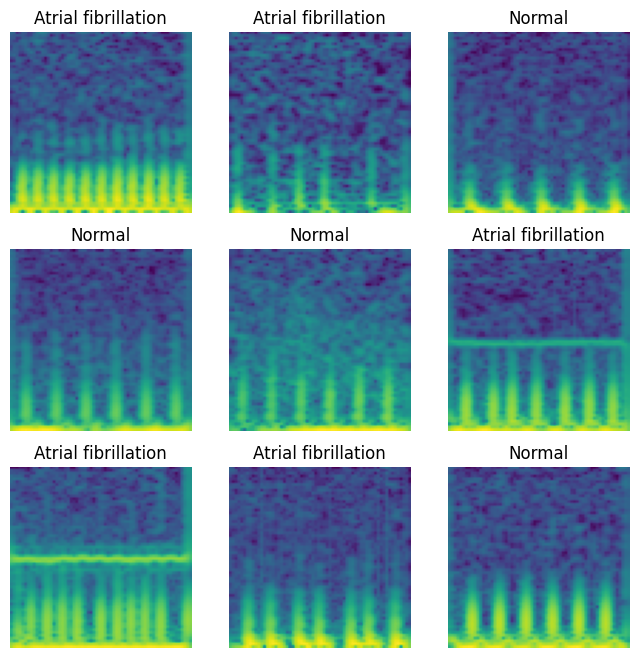

In [2]:
labels_map = {
    0: "Normal",
    1: "Atrial fibrillation"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # print(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [3]:
import torch.nn as nn
from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.dropout = nn.Dropout(0.25)
        
        self.dense1 = nn.Sequential(
            nn.Linear(6*6*64, 64),
            nn.ReLU()
        )
        
        self.dense2 = nn.Sequential(
            nn.Linear(64, 2),
            # nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dense2(x)

        return x
    
net = Net()
if torch.cuda.is_available():
    net.cuda()

summary(net, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]             416
              ReLU-2           [-1, 16, 60, 60]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10                 [-1, 2304]               0
           Linear-11                   [-1, 64]         147,520
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
Total params: 171,202
Trainable params:

In [4]:
from torch import optim
from model_trainer import ModelTrainer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

modelTrainer = ModelTrainer()

modelTrainer.train_model(
    net,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    device,
    5
)

EPOCH 1:
	batch 336 loss: 455.2533114096593
	batch 672 loss: 0.6026715157287461
	batch 1008 loss: 0.6074839456982556
	batch 1344 loss: 0.5669290025141978
	batch 1680 loss: 0.6940584044371333
LOSS train 0.6940584044371333 valid 0.6940019117964702 ACCURACY 0.5013570189476013
EPOCH 2:
	batch 336 loss: 0.6948805547186306
	batch 672 loss: 5.6132129702184885
	batch 1008 loss: 0.693500255012796
	batch 1344 loss: 0.6934228001960686
	batch 1680 loss: 0.6938156466044131
LOSS train 0.6938156466044131 valid 0.6946267913186351 ACCURACY 0.5012826323509216
EPOCH 3:
	batch 336 loss: 0.6937309563869521
	batch 672 loss: 0.6936737064804349
	batch 1008 loss: 0.6934618784912995
	batch 1344 loss: 0.6934525120471206
	batch 1680 loss: 0.6935104103315444
LOSS train 0.6935104103315444 valid 0.6944985187251891 ACCURACY 0.5012826323509216
EPOCH 4:
	batch 336 loss: 0.6934433790544668
	batch 672 loss: 0.6932311480244001
	batch 1008 loss: 0.693645065916436
	batch 1344 loss: 0.6933976738225847
	batch 1680 loss: 0.693